# <center> Projet 5 : Catégorisez automatiquement des questions sur Stack Overflow

Dans un premier temps, je vais dans un premier temps me servir de la plateforme <a href = https://data.stackexchange.com/stackoverflow/query/new>StackExchange Data Explorer</a>. Pour extraire les données qui nous servirons à développer un système de suggestion de tags pour le site Stack Overflow. Celui-ci prendra la forme d’un algorithme de machine learning qui assignera automatiquement plusieurs tags pertinents à une question.

Ensuite pour récupérer les données pertinentes, je devrais extraire des questions pertinentes et qui ont suffisament de tags .

In [1]:
%load_ext autoreload
%autoreload 2

In [38]:
# Import Python libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from bs4 import BeautifulSoup
import nltk
import joblib
import time
import spacy
import logging
logging.disable(logging.WARNING) 
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [39]:
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import EnglishStemmer
from wordcloud import WordCloud

In [4]:
nltk.download('popular')

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to C:\Users\Belal
[nltk_data]    |     ABDOUHOU\AppData\Roaming\nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to C:\Users\Belal
[nltk_data]    |     ABDOUHOU\AppData\Roaming\nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to C:\Users\Belal
[nltk_data]    |     ABDOUHOU\AppData\Roaming\nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to C:\Users\Belal
[nltk_data]    |     ABDOUHOU\AppData\Roaming\nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to C:\Users\Belal
[nltk_data]    |     ABDOUHOU\AppData\Roaming\nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downlo

True

In [5]:
df = pd.read_csv('../Query.csv')

In [6]:
df.head()

,Title,Body,Tags
0,C#'s equivalent to VB.NET's DirectCast,<p>Does C# have an equivalent to VB.NET's Dire...,<c#><vb.net><casting><directcast><ctype>
1,delegate keyword vs. lambda notation,"<p>Once it is compiled, is there a difference ...",<c#><.net><delegates><lambda><anonymous-methods>
2,"Ruby on Rails- :symbols, @iVars and ""strings"" ...",<p>New to Rails and trying to get my head arou...,<ruby-on-rails><ruby><string><symbols><instanc...
3,Record Video of Screen using .NET technologies,"<p>Is there a way to record the screen, either...",<c#><.net><video><capture><video-capture>
4,Is there any way to automate windows forms tes...,<p>I am familiar with nunit for unit testing o...,<c#><.net><vb.net><winforms><automated-tests>


In [7]:
df.tail()

,Title,Body,Tags
36713,"How can I fix the ""zsh: command not found: pyt...","<p>Since I got the <a href=""https://en.wikiped...",<python><macos><terminal><atom-editor><macos-m...
36714,`Task` blocks main thread when calling async f...,<p>I have an <code>ObservableObject</code> cla...,<ios><swift><swiftui><async-await><swift-concu...
36715,Do all pointers have the same size in C++?,"<p>Recently, I came across the following <a hr...",<c++><pointers><language-lawyer><void-pointers...
36716,Algorithm for ordering data so that neighbor e...,<p>I have a (potentially large) list <code>dat...,<python><algorithm><optimization><time-complex...
36717,'setHasOptionsMenu(Boolean): Unit' is deprecat...,<p>How do I declare a menu inside of Android f...,<android><kotlin><menu><fragment><android-infl...


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36718 entries, 0 to 36717
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Title   36718 non-null  object
 1   Body    36718 non-null  object
 2   Tags    36718 non-null  object
dtypes: object(3)
memory usage: 860.7+ KB


In [9]:
df.Title.drop_duplicates().apply(len).mean()

54.814717978048314

In [10]:
df.Body.drop_duplicates().apply(len).mean()

1401.1957078272237

In [11]:
df.Tags.drop_duplicates().apply(len).mean()

51.672945680519334

In [12]:
print('**' * 25)
print('Taille de la base de données : ', df.shape)
print('**' * 25)

**************************************************
Taille de la base de données :  (36718, 3)
**************************************************


In [13]:
# Missing values
df.isna().sum()

Title    0
Body     0
Tags     0
dtype: int64

Notre Base de données ne contient pas de valeurs manquantes.

In [14]:
# Replace open and close balise between tags
df['Tags'] = df['Tags'].str.translate(str.maketrans({'<': ' ', '>': ' '}))

In [15]:
df['Tags']

0                  c#  vb.net  casting  directcast  ctype 
1          c#  .net  delegates  lambda  anonymous-methods 
2         ruby-on-rails  ruby  string  symbols  instanc...
3                 c#  .net  video  capture  video-capture 
4             c#  .net  vb.net  winforms  automated-tests 
                               ...                        
36713     python  macos  terminal  atom-editor  macos-m...
36714     ios  swift  swiftui  async-await  swift-concu...
36715     c++  pointers  language-lawyer  void-pointers...
36716     python  algorithm  optimization  time-complex...
36717     android  kotlin  menu  fragment  android-infl...
Name: Tags, Length: 36718, dtype: object

In [16]:
def remove_html_syntax(x):
    """
    Function that remove HTML syntax in the document.
    And get the text without html syntax

    Parameters
    ----------------------------------------
    x : string
        Sequence of characters to modify.
    ----------------------------------------
    """
    sp = BeautifulSoup(x,"lxml")
    no_html = sp.get_text()
    return no_html


def remove_pos(nlp, x, pos_list):
    """
    This function will remove the unecessary part of speech
    and keep only necessary part of speech given by pos_list
    nlp : 
    Parameters
    ----------------------------------------
    nlp : model 
    x : corpus, string, Sequence of characters to modify
    pos_list : part of speech we want to keep in the corpus.
    ----------------------------------------
    """
    doc = nlp(x)
    text_list = []
    for token in doc:
        if(token.pos_ in pos_list):
            text_list.append(token.text)
    join_text = " ".join(text_list)
    join_text = join_text.lower().replace("c #", "c#")
    
    return join_text

def text_cleaner(x, nlp, pos_list):
    """
    Cleaning the corpus by removing punctuation, URLS, 
    english contractions numbers
    
    """
  
    # Remove unecessary POS not includ un pos_list
    x = remove_pos(nlp, x, pos_list)
    # Case normalization
    x = x.lower()
    # Remove unicode characters
    x = x.encode("ascii", "ignore").decode()
    # Remove English contractions
    x = re.sub("\'\w+", '', x)
    # Remove ponctuation but not # (for C# for example)
    x = re.sub('[^\\w\\s#]', '', x)
    # Remove URLs
    x = re.sub(r'http*\S+', '', x)
    # Remove numbers
    x = re.sub(r'\w*\d+\w*', '', x)
    # Remove extra whitespaces
    x = re.sub('\s+', ' ', x)
    
    # Return cleaned text
    return x


def tokenizer_fct(sentence) :
    # Tokenize the corpus using Word_tokenize
    word_tokens = word_tokenize(sentence)
    return word_tokens

# Stop words
stop_w = list(set(stopwords.words('english'))) + ['[', ']', ',', '.', ':', '?', '(', ')']


def stop_word_filter_fct(list_words) :
    filtered_w = [w for w in list_words if not w in stop_w]
    filtered_w2 = [w for w in filtered_w if len(w) > 2]
    return filtered_w2


# Lemmatizer (base d'un mot)
def lemma_fct(list_words) :
    lemmatizer = WordNetLemmatizer()
    lem_w = [lemmatizer.lemmatize(w) for w in list_words]
    return lem_w


# Fonction de préparation du texte pour le bag of words avec lemmatization
def transform_bow_lem_fct(nlp, corpus, pos_list) :
    new_corpus = remove_pos(nlp, corpus, pos_list)
    corpus_clean = text_cleaner(new_corpus, nlp, pos_list)
    word_tokens = tokenizer_fct(corpus_clean)
    sw = stop_word_filter_fct(word_tokens)
    lem_w = lemma_fct(sw)    
    transf_desc_text = ' '.join(lem_w)
    return transf_desc_text

In [17]:
df['Tags']

0                  c#  vb.net  casting  directcast  ctype 
1          c#  .net  delegates  lambda  anonymous-methods 
2         ruby-on-rails  ruby  string  symbols  instanc...
3                 c#  .net  video  capture  video-capture 
4             c#  .net  vb.net  winforms  automated-tests 
                               ...                        
36713     python  macos  terminal  atom-editor  macos-m...
36714     ios  swift  swiftui  async-await  swift-concu...
36715     c++  pointers  language-lawyer  void-pointers...
36716     python  algorithm  optimization  time-complex...
36717     android  kotlin  menu  fragment  android-infl...
Name: Tags, Length: 36718, dtype: object

In [18]:
# Apply cleaner on Body
# Spacy features
nlp = spacy.load("en_core_web_sm")
pos_list = ["NOUN","PROPN"]

In [19]:
from tqdm import tqdm
tqdm.pandas()
# Create column applying cleaning transformation
df['Body'] = df['Body'].progress_apply(lambda x : remove_html_syntax(x))
# Corp = Title + Body
df['corp'] = df.progress_apply(lambda x: x['Title'] + ' ' + x['Body'] if x['Title'] == x['Title']
                    else x['Body'], axis=1)
# Corp
df['corp_clean'] = df['corp'].progress_apply(lambda x : transform_bow_lem_fct(nlp, x, pos_list))

100%|████████████████████████████████████████████████████████████████████████████| 36718/36718 [56:11<00:00, 10.89it/s]


In [20]:
df.head()

,Title,Body,Tags,corp,corp_clean
0,C#'s equivalent to VB.NET's DirectCast,Does C# have an equivalent to VB.NET's DirectC...,c# vb.net casting directcast ctype,C#'s equivalent to VB.NET's DirectCast Does C#...,vbnet vbnet directcast cast keyword line ctype...
1,delegate keyword vs. lambda notation,"Once it is compiled, is there a difference bet...",c# .net delegates lambda anonymous-methods,delegate keyword vs. lambda notation Once it i...,delegate keyword notation difference delegate
2,"Ruby on Rails- :symbols, @iVars and ""strings"" ...",New to Rails and trying to get my head around ...,ruby-on-rails ruby string symbols instanc...,"Ruby on Rails- :symbols, @iVars and ""strings"" ...",ruby rail symbol ivars string rail symbol ivar...
3,Record Video of Screen using .NET technologies,"Is there a way to record the screen, either de...",c# .net video capture video-capture,Record Video of Screen using .NET technologies...,record video screen technology way screen desk...
4,Is there any way to automate windows forms tes...,I am familiar with nunit for unit testing of t...,c# .net vb.net winforms automated-tests,Is there any way to automate windows forms tes...,way form unit business layer test form gui lay...


In [21]:
# Regrouping all token to count it
corp_corpus, tags_corpus = [], []
for column in ['corp_clean', 'Tags']:
    for i in df.index:
        sentence = df[column][i]
        word_tokens = word_tokenize(sentence)
        if column == 'corp_clean':
            corp_corpus.extend(word_tokens)
        if column == 'Tags':
            tags_corpus.extend(word_tokens)

# Create a list of all tokens for Body
corp_corpus_dist = nltk.FreqDist(corp_corpus)
tags_corpus_dist = nltk.FreqDist(tags_corpus)

# Generate it as pandas table for most frequent word
corp_corpus_dist = pd.DataFrame(corp_corpus_dist.most_common(2000),
                                columns=['Word', 'Frequency'])
tags_corpus_dist = pd.DataFrame(tags_corpus_dist.most_common(2000),
                                columns=['Word', 'Frequency'])

In [22]:
def visualize_most_word(distribution, place):
    """
    It plots most popular word uses in corpus (title or body or corp) feature
    place = title or body or corp
    """
    fig = plt.figure(1, figsize=(16, 12))
    ax = fig.add_subplot(1, 1, 1)
    wordcloud = WordCloud(width=900, height=500,
                           max_words=100, relative_scaling=1,
                          normalize_plurals=False)\
    .generate_from_frequencies(distribution.set_index('Word').to_dict()['Frequency'])
    
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis("off") 
    plt.title("Word Cloud of 100 most popular words on {} feature\n".format(str(place)),
              fontsize=24)
    plt.show()

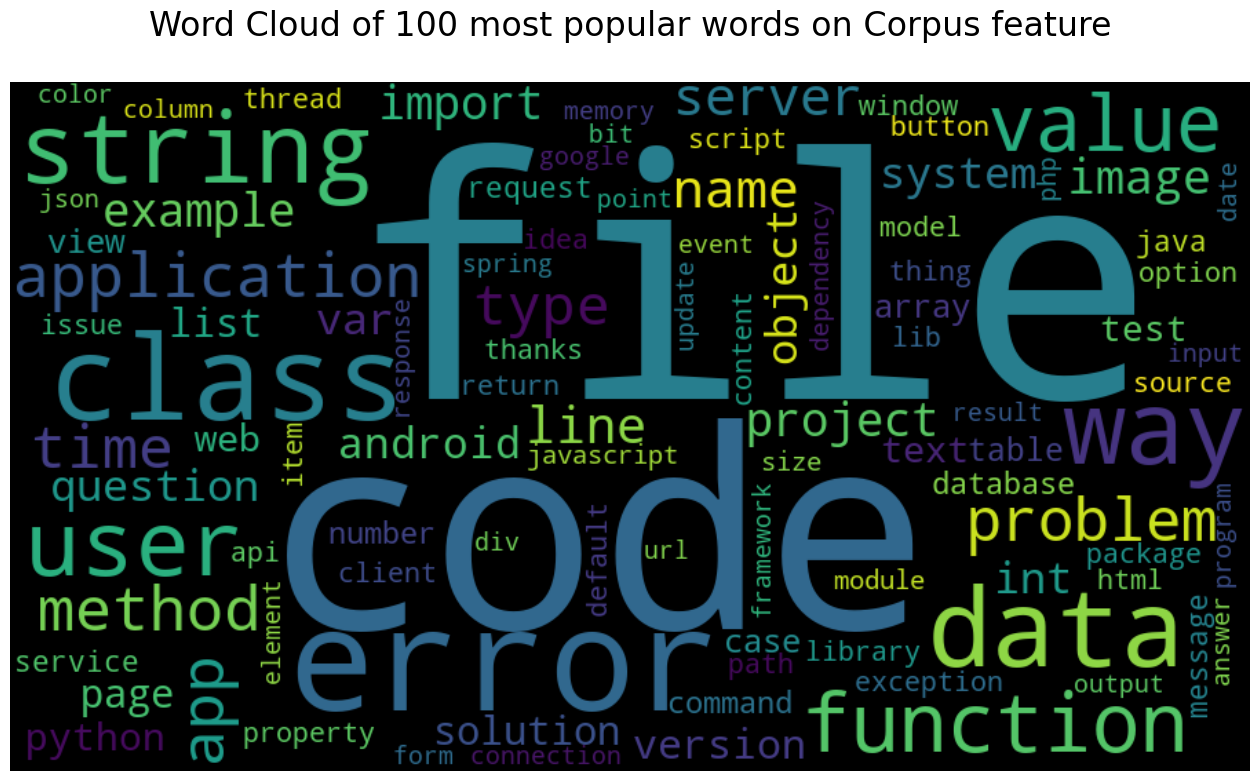

In [23]:
visualize_most_word(corp_corpus_dist, 'Corpus')

In [24]:
corp_corpus_dist[:10]

,Word,Frequency
0,file,22086
1,code,18318
2,error,18296
3,class,15009
4,data,13798
5,way,12962
6,string,12465
7,user,11501
8,function,10529
9,value,10248


In [25]:
def freq_words(x, terms=20):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()
    fdist = nltk.FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})
    
    # selecting top 20 most frequent words
    d = words_df.nlargest(columns="count", n=terms) 
  
    # visualize words and frequencies
    plt.figure(figsize=(16,16)) 
    ax = sns.barplot(data=d, x="count", y="word") 
    ax.set(ylabel='Word')
    
    for p in ax.patches:
        ax.annotate('{:.0f}'.format(p.get_width()),
                (p.get_width()+.2, p.get_y()+0.5))
    plt.show()

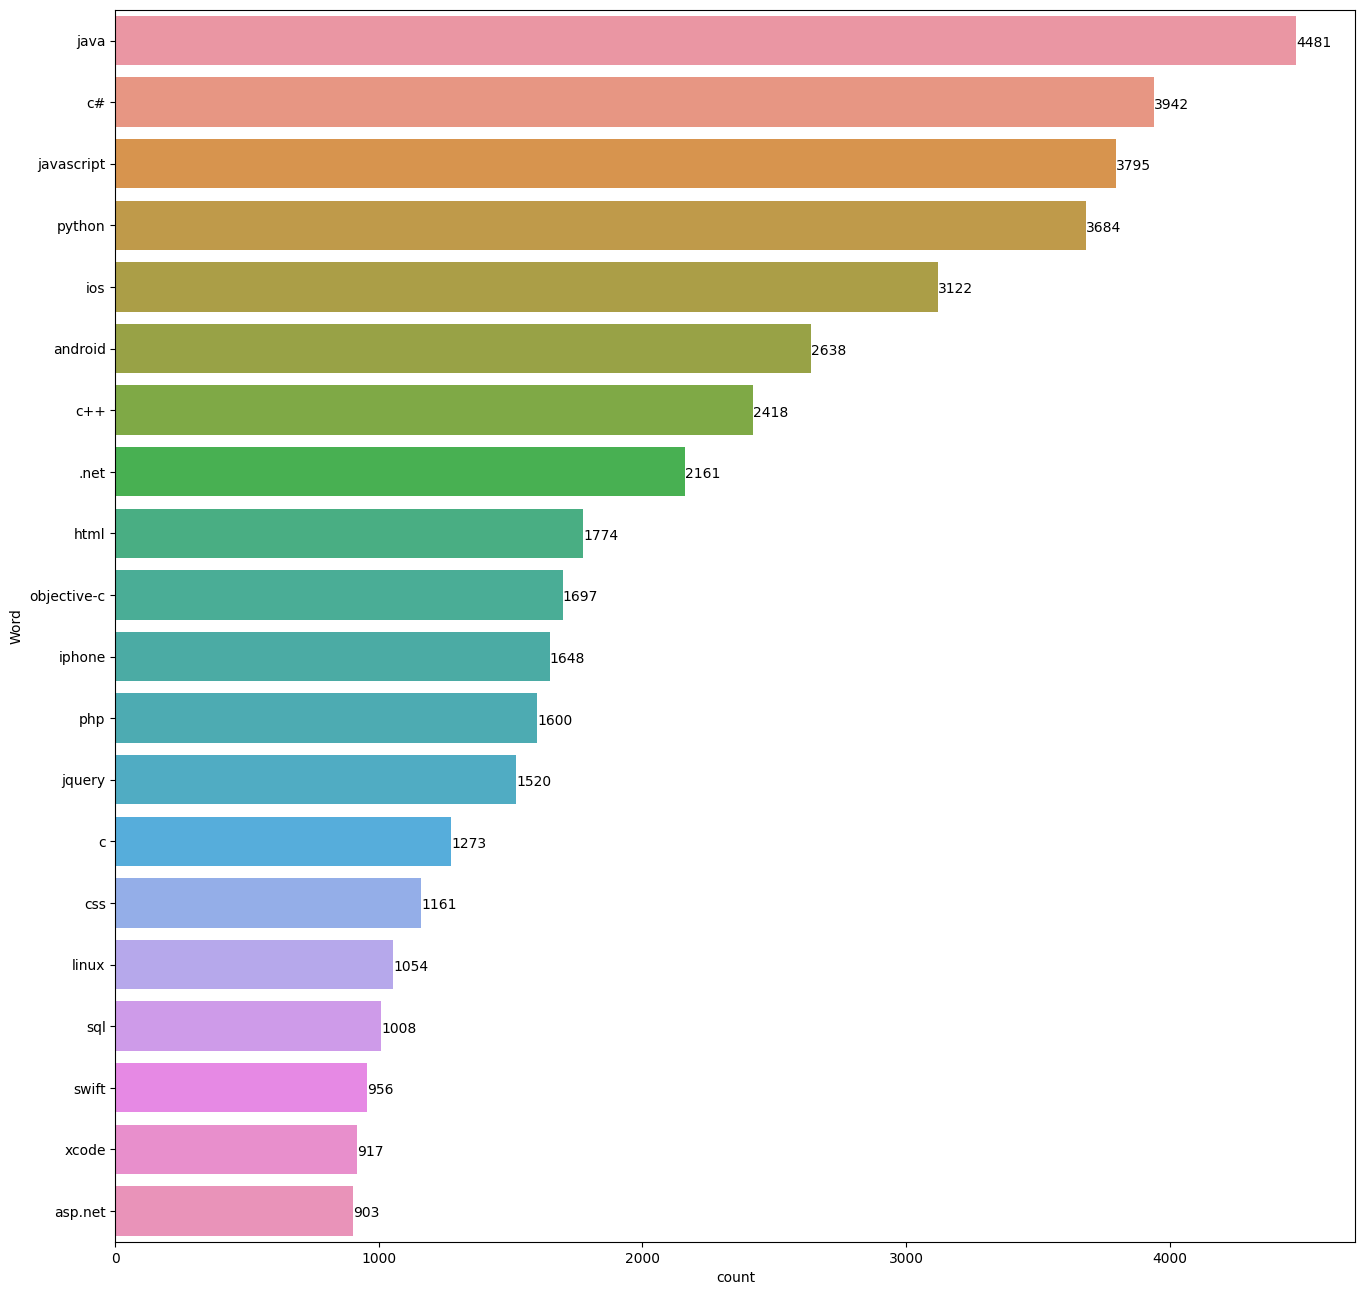

In [26]:
freq_words(df['Tags'])

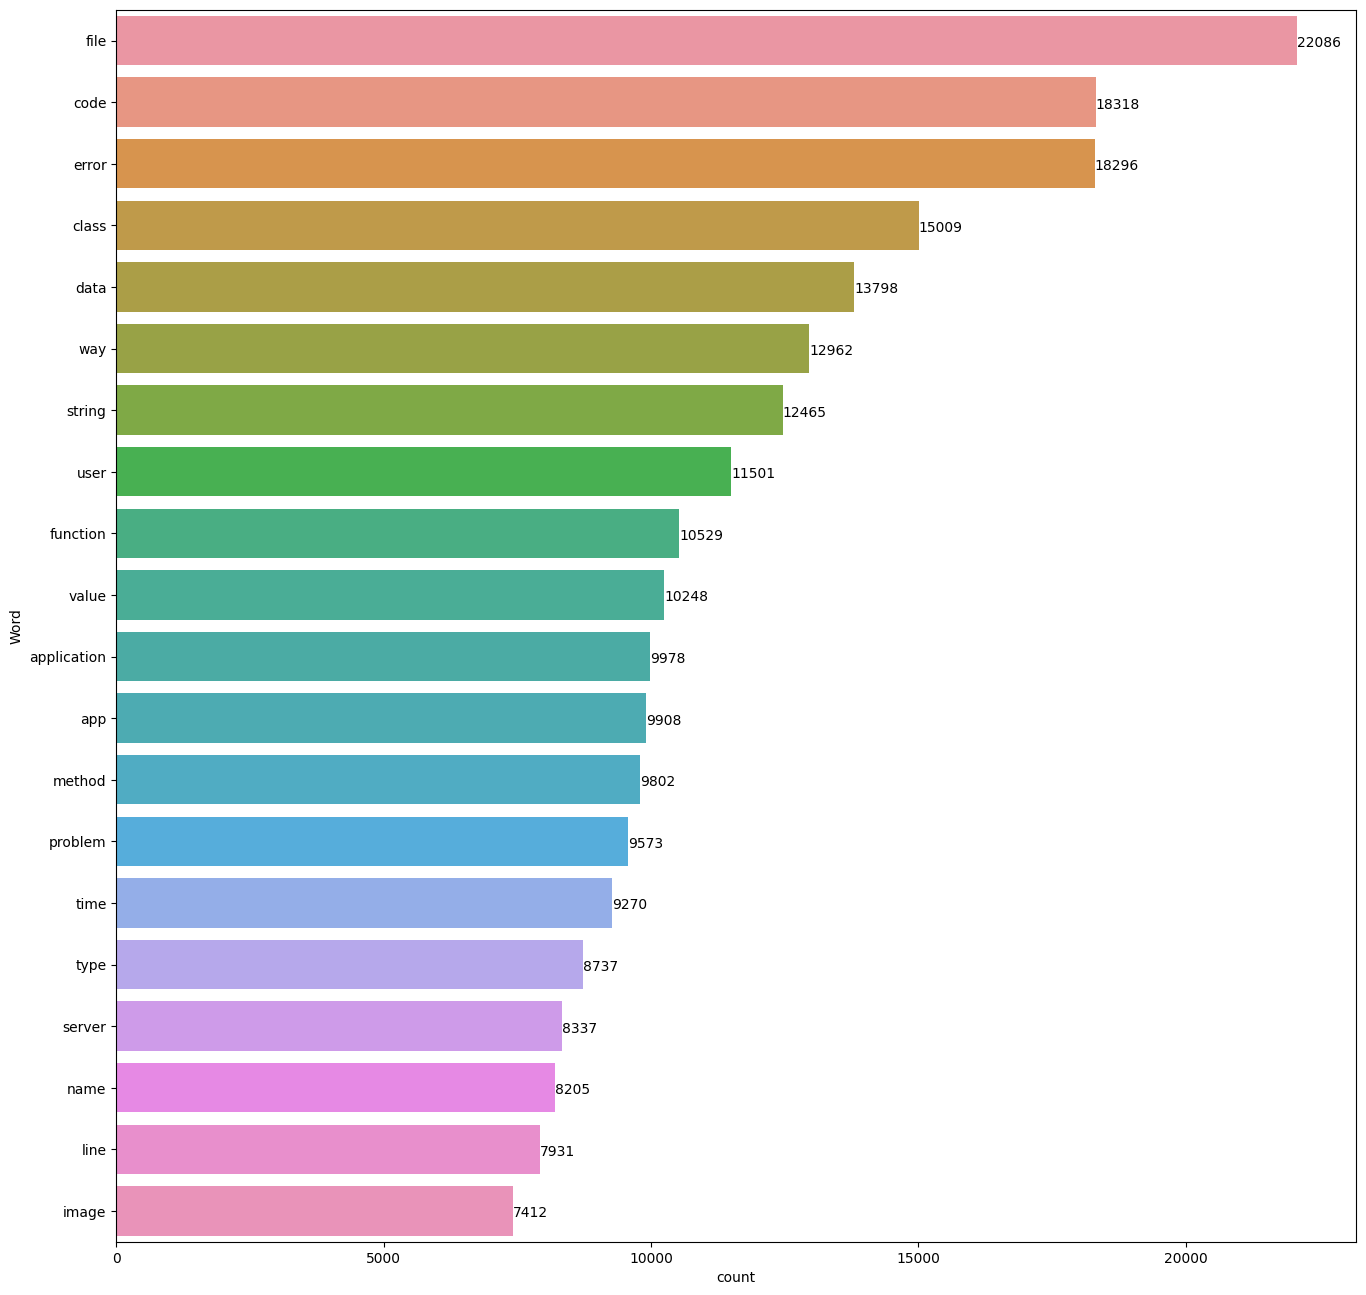

In [27]:
freq_words(df['corp_clean'])

In [28]:
Tags = [token.split(" ") for token in df['Tags']]
# Remove '' in the Tag list
for i in range(len(df)):
    for j in range(6):
        Tags[i].remove('')

In [29]:
def most_words(x, nb_occurence=100):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()
    fdist = nltk.FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})
    table_more_frequent = words_df.loc[words_df['count'] >= nb_occurence]
    more_frequent = table_more_frequent['word'].tolist()
    return more_frequent

In [30]:
tags_more_frequent = most_words(df['Tags'])

In [31]:
joblib.dump(tags_more_frequent, open("../Variables/tags_more_frequent.joblib", 'wb'))

In [32]:
df['temp'] = Tags
df['most_tags'] = ' '
for i in df.index:
    a = ""
    for j in range(5):
        if df['temp'][i][j] in tags_more_frequent:
            a = a + df['temp'][i][j] + ' '          
        df['most_tags'][i] = a
del df['temp']

In [33]:
df[['Tags', 'most_tags']]

,Tags,most_tags
0,c# vb.net casting directcast ctype,c# vb.net
1,c# .net delegates lambda anonymous-methods,c# .net lambda
2,ruby-on-rails ruby string symbols instanc...,ruby-on-rails ruby string
3,c# .net video capture video-capture,c# .net video
4,c# .net vb.net winforms automated-tests,c# .net vb.net winforms
...,...,...
36713,python macos terminal atom-editor macos-m...,python macos terminal
36714,ios swift swiftui async-await swift-concu...,ios swift async-await
36715,c++ pointers language-lawyer void-pointers...,c++ pointers
36716,python algorithm optimization time-complex...,python algorithm optimization


In [34]:
import random
i = random.randint(0, 30000)
print("=" * 30)
print("Nous choisissons une phase au hasard et montrons sa transformation effectuée")
print("-" * 10 + " Texte " + "-" * 10)
print(df['corp'][i])
print("-" * 10 + " Resultat " + "-" * 10)
print(df['corp_clean'][i])

Nous choisissons une phase au hasard et montrons sa transformation effectuée
---------- Texte ----------
Inheritance from multiple interfaces with the same method name If we have a class that inherits from multiple interfaces, and the interfaces have methods with the same name, how can we implement these methods in my class? How can we specify which method of which interface is implemented?

---------- Resultat ----------
inheritance method name class interface method name method class method interface


In [35]:
i = random.randint(0, 30000)
print("=" * 50)
print("Nous choisissons une phase au hasard et montrons sa transformation effectuée \n")
print("-" * 20 + " Texte " + "-" * 20)
print(df['corp'][i])
print("-" * 20 + " Resultat " + "-" * 20)
print(df['corp_clean'][i])

Nous choisissons une phase au hasard et montrons sa transformation effectuée 

-------------------- Texte --------------------
ASP MVC href to a controller/view I have this:
<li><a href="/Users/Index)" class="elements"><span>Clients</span></a></li>

Which works fine. But if I am already on this page or on the controller e.g. /Users/Details and I click on this link it redirects me to /Users/Index.
How can I get the correct path in the href regardless of my current position on the site?

-------------------- Resultat --------------------
asp mvc href controller view lia hrefusers index classelementsspan clientsspanali page controller detail link user index path href position site


In [36]:
i = random.randint(0, 30000)
print("=" * 50)
print("Nous choisissons une phase au hasard et montrons sa transformation effectuée \n")
print("-" * 20 + " Texte " + "-" * 20)
print(df['corp'][i])
print("-" * 20 + " Resultat " + "-" * 20)
print(df['corp_clean'][i])

Nous choisissons une phase au hasard et montrons sa transformation effectuée 

-------------------- Texte --------------------
Gingerbread emulator instance is much more sluggish than Froyo and below. Why? I'm not sure if anyone else noticed it, but the Gingerbread emulator runs like a dog, with both scrolling, navigating, interaction - all taking much longer and being much choppier. I even got an ANR in the browser when I tried to use it: http://www.androidpolice.com/2010/12/06/walkthrough-and-hands-on-with-the-gingerbread-ui-the-new-gingerbread-keyboard-in-all-its-sexiness/ (see towards the bottom).
I've just read about the new StrictMode at http://android-developers.blogspot.com/2010/12/new-gingerbread-api-strictmode.html and about all the performance improvements in Gbread, but my experience so far suggests just the opposite.
Can we get to the bottom of this? I find myself dreading bringing up an instance of Gingerbread at this point.

-------------------- Resultat ----------------

Nous pouvons sauvergarder le fichier contenant le corpus lemmatiser que nous pourrons exploiter pour appliquer les différentes modélisations.

In [37]:
df.to_csv('../clean_table_data.csv', index=False)